In [2]:
# Dependencies and Setup
from census import Census
# from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from pprint import pprint
from scipy.stats import linregress
from matplotlib import pyplot as plt
from datetime import datetime
# Import API key

# from config import g_key
Token = 'INSERT KEY HERE'

In [3]:
#Reading csv data for Wildfires
wildfire = pd.read_csv("../Wildfire_Data/wildfire_data_CA.csv", dtype={'FIPS_CODE':str})
wildfire

C:\Users\rafa_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (11,12,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,...,A,40.036944,-121.005833,5,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.933056,-120.404444,5,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.984167,-120.735556,13,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.913333,5,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.933056,5,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189545,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,...,A,40.481637,-122.389375,13,STATE OR PRIVATE,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...
189546,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,A,37.617619,-120.938570,12,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
189547,1880463,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,A,37.617619,-120.938570,12,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
189548,1880464,300348377,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,B,37.672235,-120.898356,12,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00x\xba_\xaa~9^\xc0\xb...


In [4]:
#Droppping unnecessary columns for analysis
wildfire = wildfire.drop(columns=["LOCAL_FIRE_REPORT_ID", "LOCAL_INCIDENT_ID", "STATE","OBJECTID","FOD_ID","FPA_ID", "SOURCE_SYSTEM_TYPE", "SOURCE_SYSTEM", "NWCG_REPORTING_AGENCY", "NWCG_REPORTING_UNIT_ID", "SOURCE_REPORTING_UNIT", "SOURCE_REPORTING_UNIT_NAME", "OWNER_CODE","OWNER_DESCR", "FIRE_CODE", "ICS_209_INCIDENT_NUMBER", "ICS_209_NAME", "MTBS_ID", "MTBS_FIRE_NAME", "COMPLEX_NAME", "COUNTY"])
wildfire.dtypes

NWCG_REPORTING_UNIT_NAME     object
FIRE_NAME                    object
FIRE_YEAR                     int64
DISCOVERY_DATE              float64
DISCOVERY_DOY                 int64
DISCOVERY_TIME              float64
STAT_CAUSE_CODE               int64
STAT_CAUSE_DESCR             object
CONT_DATE                   float64
CONT_DOY                    float64
CONT_TIME                   float64
FIRE_SIZE                   float64
FIRE_SIZE_CLASS              object
LATITUDE                    float64
LONGITUDE                   float64
FIPS_CODE                    object
FIPS_NAME                    object
Shape                        object
dtype: object

In [5]:
#Rewriting a cleaner csv (Makes code run faster)
wf = wildfire
wf.to_csv("wf.csv", index=False)

In [6]:
wildfire = pd.read_csv("wf.csv", dtype={"FIPS_NAME": str,'FIPS_CODE':str})

In [7]:
#Subsetting data from 2005 on
wildfire = wildfire[wildfire["FIRE_YEAR"] >= 2005]

In [8]:
#Checking the number of acres burned throuhgout the years
fs = wildfire.groupby("FIRE_YEAR")
fsum = fs["FIRE_SIZE"].sum().to_frame()
fsum["FIRE_SIZE"]

FIRE_YEAR
2005     258714.870
2006     812711.940
2007    1045291.620
2008    1430153.600
2009     455350.040
2010     120947.040
2011     192286.920
2012     764766.640
2013     581410.292
2014     546878.780
2015     848728.610
Name: FIRE_SIZE, dtype: float64

<ipython-input-9-e95fcee104b1>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(1,1,1)


Text(0.5, 1.0, 'Fires Severity throughout the years')

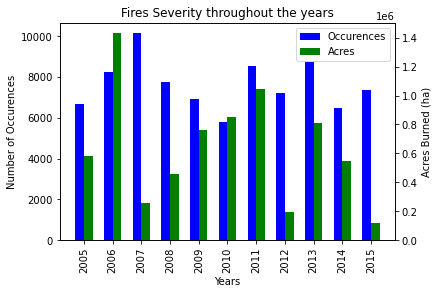

In [9]:
#Plotting the fire severity vs the Occurence
#A good way of doing this was separating two plots and plotting them on the same x axis

years = wildfire["FIRE_YEAR"].value_counts()
x = years.index
w = 0.3
plt.xticks(x + w /2, years.index, rotation='vertical')
ax1 = plt.subplot(1,1,1)

occur = ax1.bar(x, years.values, width=w, color='b', align='center', label = "Number of Ocurrences")
ax1.set_ylabel("Number of Occurences")
ax2 = ax1.twinx()
acres = ax2.bar(x + w, fsum["FIRE_SIZE"], width=w,color='g',align='center')

ax1.set_xlabel("Years")
plt.ylabel("Acres Burned (ha)")
plt.legend([occur, acres],["Occurences", 'Acres'])
plt.title("Fires Severity throughout the years")

Text(0, 0.5, 'Number of Occurrences')

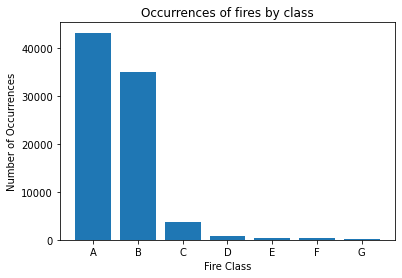

In [10]:
#Plotting Occurences By Fire Class
fsc = wildfire["FIRE_SIZE_CLASS"].value_counts()
plt.bar(fsc.index, fsc.values)
plt.title("Occurrences of fires by class")
plt.xlabel("Fire Class")
plt.ylabel("Number of Occurrences")

FIRE_SIZE_CLASS
A       4739.102
B      55239.320
C     113860.760
D     133879.420
E     243214.970
F     745493.750
G    5760813.030
Name: FIRE_SIZE, dtype: float64


Text(0, 0.5, 'Number of Acres Burned')

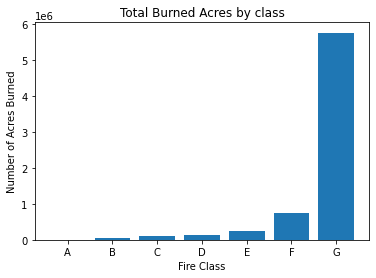

In [11]:
#Plotting Fire severity by class
burned = wildfire.groupby("FIRE_SIZE_CLASS")
acres_burned = burned['FIRE_SIZE'].sum()
pprint(acres_burned)
plt.bar(acres_burned.index, acres_burned.values)
plt.title("Total Burned Acres by class")
plt.xlabel("Fire Class")
plt.ylabel("Number of Acres Burned")

STAT_CAUSE_DESCR
Arson                 362885.590
Campfire              380046.200
Children               93377.280
Debris Burning        217168.581
Equipment Use         703392.740
Fireworks               1250.900
Lightning            3027373.320
Miscellaneous        1577044.631
Missing/Undefined     572290.100
Powerline              29290.530
Railroad               11786.730
Smoking                 6149.750
Structure              75184.000
Name: FIRE_SIZE, dtype: float64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

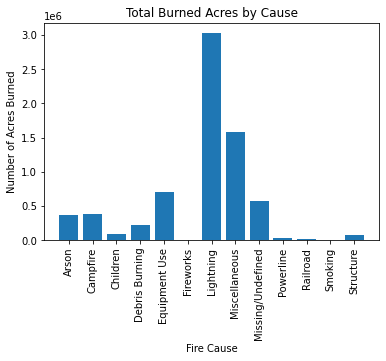

In [12]:
#Checking out the acres burned by cause of fire
burned = wildfire.groupby("STAT_CAUSE_DESCR")
acres_burned = burned['FIRE_SIZE'].sum()
pprint(acres_burned)
plt.bar(acres_burned.index, acres_burned.values)
plt.title("Total Burned Acres by Cause")
plt.xlabel("Fire Cause")
plt.ylabel("Number of Acres Burned")
plt.xticks(rotation = 90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

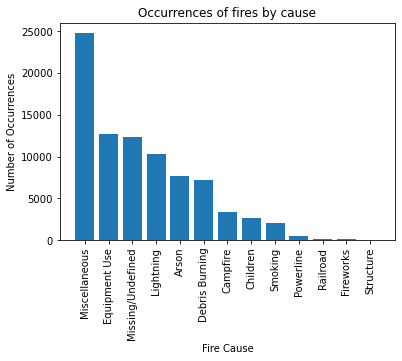

In [13]:
#Plotting the occurence of fires by cause
fsc = wildfire["STAT_CAUSE_DESCR"].value_counts()
plt.bar(fsc.index, fsc.values)
plt.title("Occurrences of fires by cause")
plt.xlabel("Fire Cause")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation = 90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text major ticklabel objects>)

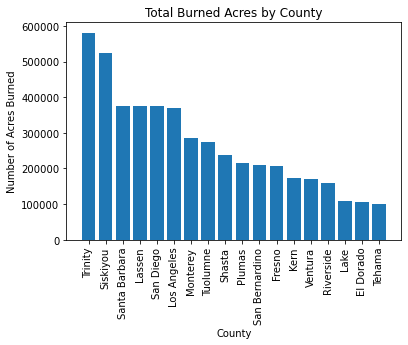

In [14]:
#Time to check some local data.
#How many acres were burned by county
burned = wildfire.groupby("FIPS_NAME")
acres_burned = burned['FIRE_SIZE'].sum()
acres_burned=acres_burned[acres_burned.values >=100000]
acres_burned.sort_values(inplace=True, ascending=False)
plt.bar(acres_burned.index, acres_burned.values)
plt.title("Total Burned Acres by County")
plt.xlabel("County")
plt.ylabel("Number of Acres Burned")
plt.xticks(rotation = 90)

<Figure size 2880x216 with 0 Axes>

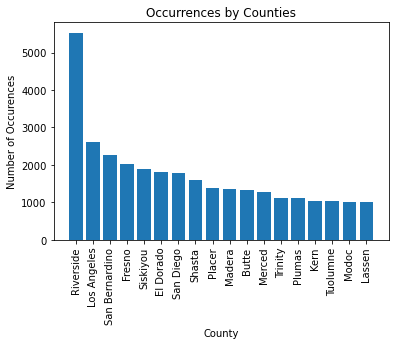

<Figure size 2880x216 with 0 Axes>

In [15]:
#Now let's see how many occurences happened by county
locs = wildfire["FIPS_NAME"].value_counts()
locs = locs[locs.values >= 1000]
plt.bar(locs.index, locs.values, width = 0.8)
plt.title("Occurrences by Counties")
plt.xlabel("County")
plt.xticks(rotation = 90)
plt.ylabel("Number of Occurences")
plt.figure(figsize=(40, 3))

<function matplotlib.pyplot.show(*args, **kw)>

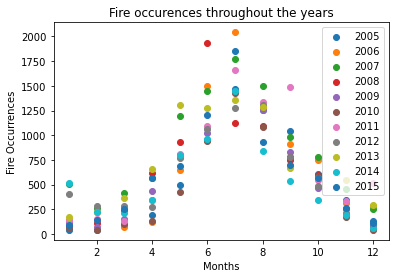

In [16]:
#A good way to see a season trend is to plot the occurences throughout the months
#This way we looped through all 10 years to have a better idea of what's happening
wildfire['DATE'] = pd.to_datetime(wildfire['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
wildfire['MONTH'] = pd.DatetimeIndex(wildfire['DATE']).month

yr = wildfire.groupby("FIRE_YEAR")

gry = []

for year, data in yr:
    months = data["MONTH"].value_counts()
    plt.scatter(months.index, months.values)
    gry.append(year)

    
plt.xlabel("Months")
plt.ylabel("Fire Occurrences")
plt.legend(gry)
plt.title("Fire occurences throughout the years")
plt.show

In [160]:
#Setting up some empty lists to acquire NOAA Data
years=[]
months=[]
fips_code=[]
temps=[]
wind=[]
precip=[]


query_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GSOM&units=standard&limit=1000'

In [161]:
#We are just using counties with more than 1000 fires in total to make the data a little smaller
counties = wildfire["FIPS_CODE"].value_counts()
counties = counties[counties.values >= 1000]
pprint(counties.index) 

Index(['065', '037', '071', '019', '093', '017', '073', '089', '061', '039',
       '007', '047', '105', '063', '109', '029', '049', '035'],
      dtype='object')


## This is the temperature NOAA API we used, because it took a long time to run we decided not to run the other two parameters.

In [171]:
#takes about 20 minutes to run
years=[]
months=[]
fips_code=[]
temps=[]
wind=[]
precip=[]

for code in counties.index:
    pprint(code)
    for year in range(2005,2016,1):
        pprint(year)
        for month in range(1,13,1):
            #request for temperature data
            try:
                responseTEMP = requests.get(query_url+f'&datatypeid=TMAX&locationid=FIPS:06{code}&startdate={year}-{month:02.0f}-01&enddate={year}-{month:02.0f}-01',headers = {'token':Token}).json()
                calc_temp=0
                avg_temp=0
                for y in range(len(responseTEMP['results'])):
                    calc_temp+=responseTEMP['results'][y]['value']
                    avg_temp=calc_temp/len(responseTEMP['results'])
                temps.append(avg_temp)

                years.append(year)
                months.append(month)
                fips_code.append(code)
                
            except:
                pprint('error occurred, appending 0 placeholder to all values')
                temps.append(0)
                years.append(year)
                months.append(month)
                fips_code.append(code)


'065'
2005
2006
2007
2008
2009
2010
'error occurred, appending 0 placeholder to all values'
2011
2012
2013
2014
2015
'037'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'071'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'019'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'093'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'017'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'073'
2005
2006
2007
2008
2009
2010
2011
2012
'error occurred, appending 0 placeholder to all values'
2013
2014
2015
'089'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'061'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'039'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'007'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'047'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'105'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'063'
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
'109'
2005
2006
2007
2008
2009
201

In [174]:
NOAA_data={'FIPS_CODE':fips_code,'YEAR':years,'MONTH':months,'TMAX':temps}
NOAA_df=pd.DataFrame(NOAA_data)
NOAA_df

,FIPS_CODE,YEAR,MONTH,TMAX
0,065,2005,1,63.500000
1,065,2005,2,63.240000
2,065,2005,3,70.582609
3,065,2005,4,77.275000
4,065,2005,5,85.775000
...,...,...,...,...
2371,035,2015,8,84.375000
2372,035,2015,9,78.130769
2373,035,2015,10,68.323077
2374,035,2015,11,44.307692


In [215]:
#Let's drop the counties that have less than 1000 fires
drops = wildfire["FIPS_CODE"].value_counts()
drops = drops[drops.values <= 1000]
labels=drops.index
pprint(labels)

wf_select=wildfire
for x in range(len(labels)):
    wf_select=wf_select.drop(wildfire[wildfire['FIPS_CODE']==labels[x]].index)

wildfire_group = wf_select.groupby(['FIPS_CODE','FIRE_YEAR','MONTH'])
severity_df = pd.DataFrame(wildfire_group['FIRE_SIZE'].sum())
temp_df = severity_df.merge(NOAA_df, how='left',left_on=['FIPS_CODE','FIRE_YEAR','MONTH'],right_on=['FIPS_CODE','YEAR','MONTH'])

Index(['023', '103', '057', '009', '045', '097', '107', '079', '053', '051',
       '013', '115', '087', '067', '033', '059', '005', '043', '055', '085',
       '091', '077', '027', '003', '001', '099', '015', '113', '083', '081',
       '069', '095', '025', '111', '031', '021', '011', '041', '101', '075'],
      dtype='object')


<function show at 0x0000027FC6F74E18>

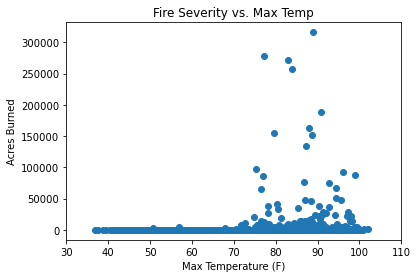

In [223]:
#Scatter plot of severity vs Max Temp
#We can see that fires tend to get worse above 75F
plt.scatter(temp_df['TMAX'],temp_df['FIRE_SIZE'],)
plt.xlabel("Max Temperature (F)")
plt.ylabel("Acres Burned")
plt.title("Fire Severity vs. Max Temp")
plt.xlim(30,110)
plt.show

## This two cells bellow would give us the precipitation and wind data

In [ ]:
#takes about 20 minutes to run
for code in counties.index:
    pprint(code)
    for year in range(2005,2016,1):
        pprint(year)
        for month in range(1,13,1):
            #request for precipitation data
            try:
                responsePRCP = requests.get(query_url+f'&datatypeid=PRCP&locationid=FIPS:06{code}&startdate={year}-{month:02.0f}-01&enddate={year}-{month:02.0f}-01',headers = {'token':Token}).json()
                calc_prcp=0
                avg_prcp=0
                for x in range(len(responsePRCP['results'])):
                    calc_prcp+=responsePRCP['results'][x]['value']
                    avg_prcp=calc_prcp/len(responsePRCP['results'])
                precip.append(avg_prcp)
            except:
                pprint('error occurred, appending 0 placeholder to all values')
                precip.append(0)


In [ ]:
#takes about 20 minutes to run
for code in counties.index:
    pprint(code)
    for year in range(2005,2016,1):
        pprint(year)
        for month in range(1,13,1):
            #request for wind data
            try:
                responseWIND = requests.get(query_url+f'&datatypeid=AWND&locationid=FIPS:06{code}&startdate={year}-{month:02.0f}-01&enddate={year}-{month:02.0f}-01',headers = {'token':Token}).json()
                calc_wind=0
                avg_wind=0
                for z in range(len(responseWIND['results'])):
                    calc_wind+=responseWIND['results'][z]['value']
                    avg_wind=calc_wind/len(responseWIND['results'])
                wind.append(avg_wind)
            except:
                pprint('error occurred, appending 0 placeholder to all values')
                wind.append(0)


In [166]:
response = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GSOM&units=standard&limit=1000&datatypeid=TMAX&locationid=FIPS:06017&startdate=2013-08-01&enddate=2013-08-01',headers = {'token':Token}).json()

In [168]:
calc=0
avg=0
for x in range(len(response['results'])):
    calc+=response['results'][x]['value']
    avg=calc/len(response['results'])
avg


79.85384615384616

In [17]:
#Configuring gmaps with api key
gmaps.configure(api_key="INSERT KEY HERE")

In [18]:
#Calling out the heat map
locations = wildfire[["LATITUDE","LONGITUDE"]].astype(float)


fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=wildfire["FIRE_SIZE"],
                                 dissipating=False, max_intensity=0.99,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig


Figure(layout=FigureLayout(height='420px'))